In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
import copy

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [23]:
# --- DATA LOADING (Updated for Vector B-Fields) ---
# Note: We now assume 'brain_physics_meta.npz' is generated correctly by fenics_1.py
# (i.e. points are already filtered/generated strictly inside the brain).

try:
    from google.colab import files
    if not os.path.exists('meg_training_data.npz'): files.upload()
    if not os.path.exists('brain_physics_meta.npz'): files.upload()
except ImportError:
    pass

data = np.load('meg_training_data.npz')
geo = np.load('brain_physics_meta.npz')

# 1. Prepared Training Data
X_raw = data['X']

# Handle Flattening of Vector Fields
if len(X_raw.shape) == 3:
    print(f"Detected Vector B-Fields: {X_raw.shape} -> Flattening to (N, {X_raw.shape[1]*3})")
    X_raw = X_raw.reshape(X_raw.shape[0], -1)
else:
    print(f"Detected Scalar B-Fields: {X_raw.shape}")

# --- NORMALIZATION STRATEGY (FIXED) ---
# Problem: 1/r^3 dipole fields create massive outliers (singularities near sensors).
# Using pure 'max_abs' squashes 99% of useful data to 0.
# Solution: Use 99.5th Percentile (Robust Scaling).
normalization_type = 'robust_max'

if normalization_type == 'robust_max':
    flat_abs = np.abs(X_raw)
    # Scale by the 99.5th percentile (ignoring top 0.5% outliers)
    global_scale = np.percentile(flat_abs, 99.5)

    print(f"Input Normalization (Robust): Scale factor {global_scale:.2e} T")
    print("   (Data will be clipped to [-1, 1] to handle the remaining outliers)")

    X_norm = X_raw / (global_scale + 1e-16)
    X_norm = np.clip(X_norm, -1.0, 1.0) # Clip outliers to avoid exploding gradients

elif normalization_type == 'max_abs':
    global_max = np.max(np.abs(X_raw))
    X_norm = X_raw / (global_max + 1e-16)
    print(f"Input Normalization (MaxAbs): Scale factor {global_max:.2e} T")
else:
    X_mean, X_std = np.mean(X_raw), np.std(X_raw)
    X_norm = (X_raw - X_mean) / (X_std + 1e-16)
    print(f"Input Normalization (Z-Score): Mean {X_mean:.2e}, Std {X_std:.2e}")

# 2. TARGETS (Geometry): Scale Meters to Normalized Space
Y_raw = data['Y']
# Vector Normalization: Scale each axis independently to [-1, 1] range based on bounds
max_coords = np.max(np.abs(Y_raw), axis=0) # [x_max, y_max, z_max]
COORD_SCALE_VEC = 1.0 / (max_coords + 1e-8) # Inverse of max extent

print(f"Target Normalization (Vector): Max Extents {max_coords} (m)")
print(f"   Scaling Factors: {COORD_SCALE_VEC}")

# Apply broadcast multiplication
Y_norm = Y_raw * COORD_SCALE_VEC

# Define Global Tensor for Unscaling in Physics Loss (Must be on Device)
# This allows (Norm / Scale) -> Meters
COORD_SCALE_TENS = torch.tensor(COORD_SCALE_VEC, dtype=torch.float32).to(device)

# Split Train/Val (80/20)
n_total = len(X_norm)
n_train = int(0.8 * n_total)
indices = np.random.RandomState(42).permutation(n_total)

X_train = torch.tensor(X_norm[indices[:n_train]], dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_norm[indices[:n_train]], dtype=torch.float32).to(device)
X_val = torch.tensor(X_norm[indices[n_train:]], dtype=torch.float32).to(device)
Y_val = torch.tensor(Y_norm[indices[n_train:]], dtype=torch.float32).to(device)

# 2. Prepare Geometry (For PINN only)
# Just load raw, assuming they are now correct
interior_pts_filtered = geo['interior_pts'] # Meters
print(f"Loaded Geometry: {len(interior_pts_filtered)} interior points.")

interior_pts_fixed = torch.tensor(interior_pts_filtered, dtype=torch.float32).to(device)

# Load Surface Points and Normals
surf_pts = geo['surface_midpoints'] if 'surface_midpoints' in geo else geo['surface_pts']
surf_pts_fixed = torch.tensor(surf_pts, dtype=torch.float32).to(device)
surf_normals_fixed = torch.tensor(geo['surface_normals'], dtype=torch.float32).to(device)

print(f"Train Set: {len(X_train)} samples | Val Set: {len(X_val)} samples")
print(f"Input Feature Dimension: {X_train.shape[1]}")

Detected Vector B-Fields: (5000, 320, 3) -> Flattening to (N, 960)
Input Normalization (Robust): Scale factor 5.70e-11 T
   (Data will be clipped to [-1, 1] to handle the remaining outliers)
Target Normalization (Vector): Max Extents [0.0204614  0.02717392 0.01644696] (m)
   Scaling Factors: [48.8724836  36.79997807 60.80146901]
Loaded Geometry: 10000 interior points.
Train Set: 4000 samples | Val Set: 1000 samples
Input Feature Dimension: 960


In [24]:
# Calculate the maximum normalized radius from your interior points
with torch.no_grad():
    # norm calculates the distance from (0,0,0) for each point
    brain_radii = torch.norm(interior_pts_fixed * COORD_SCALE_TENS, dim=1)
    MAX_RADIUS = brain_radii.max().item()

print(f"The anatomical boundary (MAX_RADIUS) is: {MAX_RADIUS:.4f}")

# --- IMPROVED MODEL DEFINITION (Physics-Informed) ---
class ConditionalMEGPinn(nn.Module):
    def __init__(self, n_sensors, n_hidden=256, max_radius=1.8):
        super().__init__()
        self.max_radius = max_radius

        # Inverter: Now ends with Tanh to squash outputs to [-1, 1]
        self.inverter = nn.Sequential(
            nn.Linear(n_sensors, n_hidden), nn.GELU(),
            nn.Linear(n_hidden, n_hidden), nn.GELU(),
            nn.Linear(n_hidden, 3),
            nn.Tanh()
        )

        # Potential Net (Remains the same as your v15 notebook)
        self.potential_net = nn.Sequential(
            nn.Linear(6, n_hidden), nn.SiLU(),
            nn.Linear(n_hidden, n_hidden), nn.SiLU(),
            nn.Linear(n_hidden, n_hidden), nn.SiLU(),
            nn.Linear(n_hidden, 1)
        )

    def predict_source(self, b_field):
        # Scale the Tanh output (-1 to 1) by the brain's max radius
        # This mathematically prevents "escaped" points
        return self.inverter(b_field) * self.max_radius

    def predict_potential(self, inputs):
        # Potential magnitude scaling (2e-4) from your v15 notebook
        return self.potential_net(inputs) * 2e-4

# --- Updated Training Loop Fragment ---
# When you initialize the model, pass the MAX_RADIUS calculated above
model = ConditionalMEGPinn(
    n_sensors=X_train.shape[1],
    n_hidden=256,
    max_radius=MAX_RADIUS
).to(device)

# NOTE: compute_physics_loss is defined later in the notebook (Cell 5)
# and returns a tuple (phy, bc).
# We remove the definition here to avoid conflicts/inconsistencies.


The anatomical boundary (MAX_RADIUS) is: 1.1840


In [25]:
# --- TRAINING FUNCTION ---
def train_experiment(name, use_physics=False, epochs=150, lr=1e-3, data_fraction=1.0, n_hidden=256, phy_scale=0.05):
    print(f"\n>>> Starting Experiment: {name}")
    print(f"    Physics Loss: {'ENABLED' if use_physics else 'DISABLED'}")
    if use_physics:
         print(f"    Params: LR={lr:.0e}, Hidden={n_hidden}, PhyScale={phy_scale}")

    # Create Subset
    n_subset = int(len(X_train) * data_fraction)
    print(f"    Training on {n_subset}/{len(X_train)} samples ({data_fraction:.0%} of data)")

    X_train_sub = X_train[:n_subset]
    Y_train_sub = Y_train[:n_subset]

    # Initialize fresh model
    model = ConditionalMEGPinn(X_train.shape[1], n_hidden=n_hidden).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, factor=0.5)
    loss_fn = nn.MSELoss()

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_error_cm': [],
        'loss_data': [],   # To track Data term
        'loss_phy': [],    # To track PDE term
        'loss_bc': []      # To track BC term
    }

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n_subset)
        epoch_loss = 0

        # Track individual components for the epoch
        accum_data = 0.0
        accum_phy = 0.0
        accum_bc = 0.0

        for i in range(0, n_subset, 32):
            idx = perm[i:i+32]
            X_b, Y_b = X_train_sub[idx], Y_train_sub[idx]

            optimizer.zero_grad()
            pred = model.predict_source(X_b)
            loss_data = loss_fn(pred, Y_b)

            # Loss is initially just data loss
            total_batch_loss = loss_data
            accum_data += loss_data.item()

            loss_pde_item = 0.0
            loss_bc_item = 0.0

            if use_physics:
                if epoch >= 10:
                    ramp = min(1.0, (epoch - 10) / 20.0)
                    phy_weight = phy_scale * ramp

                    # Compute components separately
                    phy_term, bc_term = compute_physics_loss(model, pred)

                    # Weighted Physics Loss
                    total_phy_loss = phy_weight * (phy_term + bc_term)
                    total_batch_loss += total_phy_loss

                    loss_pde_item = (phy_weight * phy_term).item()
                    loss_bc_item = (phy_weight * bc_term).item()

                    accum_phy += loss_pde_item
                    accum_bc += loss_bc_item

            total_batch_loss.backward()
            optimizer.step()
            epoch_loss += total_batch_loss.item()

        # Normalize accumulators
        n_batches = n_subset / 32
        history['train_loss'].append(epoch_loss / n_batches)
        history['loss_data'].append(accum_data / n_batches)
        history['loss_phy'].append(accum_phy / n_batches)
        history['loss_bc'].append(accum_bc / n_batches)

        # Validation
        model.eval()
        with torch.no_grad():
            pred_val_norm = model.predict_source(X_val)
            # MSE on Normalized Coords
            val_loss = loss_fn(pred_val_norm, Y_val).item()

            # Calculate Physical Error in cm
            # Unscale: Norm -> Meters -> Centimeters
            pred_m = pred_val_norm / COORD_SCALE_TENS
            target_m = Y_val / COORD_SCALE_TENS

            diff_m = (pred_m - target_m).cpu().numpy()
            err_cm = np.mean(np.linalg.norm(diff_m, axis=1)) * 100

        scheduler.step(val_loss)
        history['val_loss'].append(val_loss)
        history['val_error_cm'].append(err_cm)

        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Total: {history['train_loss'][-1]:.2e} | Data: {history['loss_data'][-1]:.2e} | PDE: {history['loss_phy'][-1]:.2e} | BC: {history['loss_bc'][-1]:.2e} | Val Err: {err_cm:.2f} cm")

    duration = time.time() - start_time
    print(f"Done. Duration: {duration:.1f}s | Final Error: {history['val_error_cm'][-1]:.2f} cm")
    return history, model

In [ ]:
def compute_physics_loss(model, pred_source_norm):
    # Updated to return components separately

    # Validation on Random Subset (Batch of 4)
    batch_size = pred_source_norm.shape[0]
    idx = torch.randperm(batch_size)[:4]
    selected_norm = pred_source_norm[idx]

    # Constants (Physical Units)
    SPREAD = 0.005 # Meters
    MOMENT = 1e-8  # Am
    SIGMA_Cond = 0.33 # S/m
    NORM_FACTOR = 1.0 / ((SPREAD * np.sqrt(2*np.pi))**3)

    total_phy, total_bc = 0, 0

    # Pre-fetch geometry (METERS)
    xyz_interior_m = interior_pts_fixed.detach().clone()
    xyz_interior_m.requires_grad = True

    xyz_surf_m = surf_pts_fixed.detach().clone()
    xyz_surf_m.requires_grad = True

    for i in range(len(selected_norm)):
        src_norm = selected_norm[i].unsqueeze(0) # (1, 3) Normalized

        # Recover Physical Source Position for PDE source term
        src_m = src_norm / COORD_SCALE_TENS

        # 1. Interior Domain - Poisson
        # Subsample interior points
        perm = torch.randperm(xyz_interior_m.shape[0])[:500]
        xyz_batch_m = xyz_interior_m[perm]

        # Prepare Inputs for Potential Net (Must be Normalized)
        # [Location_Norm, SourcePos_Norm]
        xyz_batch_norm = xyz_batch_m * COORD_SCALE_TENS
        inputs = torch.cat([xyz_batch_norm, src_norm.repeat(len(xyz_batch_m), 1)], dim=1)

        # Predict Potential
        V = model.predict_potential(inputs)

        # Compute Laplacian (w.r.t Physical Coordinates Meters)
        grad_V = torch.autograd.grad(V.sum(), xyz_batch_m, create_graph=True)[0]
        laplacian = 0
        for j in range(3):
            grad_grad = torch.autograd.grad(grad_V[:, j].sum(), xyz_batch_m, create_graph=True)[0]
            laplacian += grad_grad[:, j]

        # Source Term (Gaussian Approximation)
        diff = xyz_batch_m - src_m
        dist_sq = torch.sum(diff**2, dim=1).unsqueeze(1)

        gaussian = torch.exp(-torch.clamp(dist_sq, max=0.1) / (2 * SPREAD**2)) * NORM_FACTOR
        m_dot_r = MOMENT * diff[:, 0].unsqueeze(1) # Dipole in X
        term_source = (m_dot_r / (SPREAD**2)) * gaussian

        # PDE Residual
        res_pde = (SIGMA_Cond * laplacian.unsqueeze(1)) + term_source
        total_phy += torch.mean(res_pde**2)

        # 2. Boundary Condition (Neumann)
        perm_s = torch.randperm(xyz_surf_m.shape[0])[:200]
        xyz_s_batch_m = xyz_surf_m[perm_s]
        normals_batch = surf_normals_fixed[perm_s]

        # Inputs normalized
        xyz_s_batch_norm = xyz_s_batch_m * COORD_SCALE_TENS
        inputs_s = torch.cat([xyz_s_batch_norm, src_norm.repeat(len(xyz_s_batch_m), 1)], dim=1)

        V_s = model.predict_potential(inputs_s)

        # Grad w.r.t Meters
        grad_V_s = torch.autograd.grad(V_s.sum(), xyz_s_batch_m, create_graph=True)[0]
        flux = torch.sum(grad_V_s * normals_batch, dim=1)
        total_bc += torch.mean(flux**2)

    # Return components separately (Mean per sample in batch)
    N = len(selected_norm) + 1e-9
    return total_phy / N, total_bc / N


>>> Starting PINN Hyperparameter Search (12 trials)
Trial  | LR       | Hidden   | PhyW     | Error (cm)
-------------------------------------------------------
1      | 5e-04    | 256      | 5e-02    | 0.63
2      | 1e-03    | 256      | 2e-01    | 0.50
3      | 5e-04    | 512      | 2e-01    | 0.59
4      | 2e-03    | 256      | 2e-01    | 0.48
5      | 1e-03    | 512      | 5e-02    | 0.49
6      | 5e-04    | 512      | 2e-01    | 0.59
7      | 5e-04    | 256      | 1e-02    | 0.61
8      | 5e-04    | 256      | 1e-02    | 0.64
9      | 2e-03    | 256      | 1e-01    | 0.45
10     | 5e-04    | 512      | 1e-01    | 0.58
11     | 5e-04    | 512      | 1e-01    | 0.57
12     | 2e-03    | 512      | 1e-02    | 0.46

=== TOP CONFIGURATION ===
Error: 0.45 cm
Config: {'lr': np.float64(0.002), 'n_hidden': 256, 'phy_weight': np.float64(0.1)}


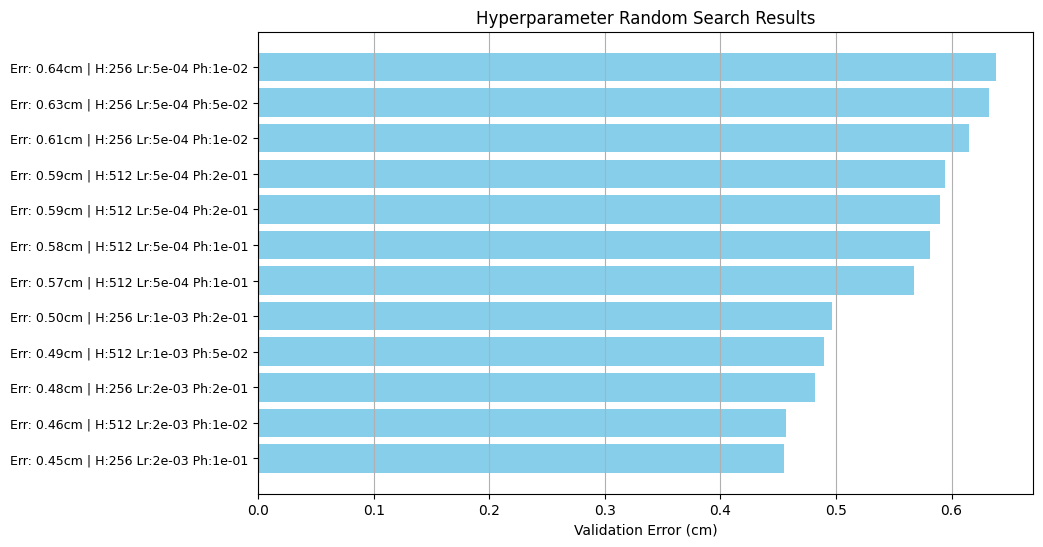

In [ ]:
# --- HYPERPARAMETER OPTIMIZATION FOR PINN ---

def train_pinn_for_hpo(config, epochs=50):
    # Unpack config
    lr = config.get('lr', 1e-3)
    n_hidden = config.get('n_hidden', 256)
    phy_weight = config.get('phy_weight', 1e-2)

    # 10% Data Subset (Validate on scarce data as it's the hardest task)
    n_subset = int(len(X_train) * 0.1)
    X_sub = X_train[:n_subset]
    Y_sub = Y_train[:n_subset]

    model = ConditionalMEGPinn(X_train.shape[1], n_hidden=n_hidden).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n_subset)

        for i in range(0, n_subset, 32):
            idx = perm[i:i+32]
            X_b, Y_b = X_sub[idx], Y_sub[idx]

            optimizer.zero_grad()
            pred = model.predict_source(X_b)
            loss = loss_fn(pred, Y_b)

            if epoch >= 5:
                ramp = min(1.0, (epoch - 5) / 10.0)
                # compute_physics_loss now returns tuple (phy, bc)
                phy_val, bc_val = compute_physics_loss(model, pred)
                loss += (phy_weight * ramp) * (phy_val + bc_val)

            loss.backward()
            optimizer.step()

    # Validation Metric (in CM)
    model.eval()
    with torch.no_grad():
        pred_val_norm = model.predict_source(X_val)

        # Unscale
        pred_cm = (pred_val_norm / COORD_SCALE_TENS) * 100.0
        target_cm = (Y_val / COORD_SCALE_TENS) * 100.0

        diff = (pred_cm - target_cm).cpu().numpy()
        err_cm = np.mean(np.linalg.norm(diff, axis=1))

    return err_cm

def run_hyperparameter_optimization(n_trials=10):
    print(f"\n>>> Starting PINN Hyperparameter Search ({n_trials} trials)")

    # Search Space
    space = {
        'lr': [1e-3, 5e-4, 2e-3],
        'n_hidden': [256, 512],
        'phy_weight': [0.01, 0.05, 0.1, 0.2]
    }

    results = []
    print(f"{'Trial':<6} | {'LR':<8} | {'Hidden':<8} | {'PhyW':<8} | {'Error (cm)':<10}")
    print("-" * 55)

    for i in range(n_trials):
        config = {
            'lr': np.random.choice(space['lr']),
            'n_hidden': int(np.random.choice(space['n_hidden'])),
            'phy_weight': np.random.choice(space['phy_weight'])
        }

        err = train_pinn_for_hpo(config, epochs=40)
        results.append((err, config))
        print(f"{i+1:<6} | {config['lr']:<8.0e} | {config['n_hidden']:<8} | {config['phy_weight']:<8.0e} | {err:.2f}")

    results.sort(key=lambda x: x[0])
    best = results[0]

    print("\n=== TOP CONFIGURATION ===")
    print(f"Error: {best[0]:.2f} cm")
    print(f"Config: {best[1]}")

    return best[1], results

# 1. Run Optimization
best_config, all_res = run_hyperparameter_optimization(n_trials=12)

# 2. Visualization
errors = [r[0] for r in all_res]
plt.figure(figsize=(12, 8)) # Increased figure size
plt.barh(range(len(errors)), errors, color='skyblue')
labels = [f"Err: {r[0]:.2f}cm | H:{r[1]['n_hidden']} Lr:{r[1]['lr']:.0e} Ph:{r[1]['phy_weight']:.0e}" for r in all_res]
plt.yticks(range(len(errors)), labels, fontsize=12); # Increased font size
plt.xlabel('Validation Error (cm)', fontsize=14); # Increased font size
plt.title('Hyperparameter Random Search Results', fontsize=16) # Increased font size
plt.grid(axis='x')
plt.tight_layout()
plt.show()


=== EXPERIMENT 1: Full Data (100%) ===
Using Optimal Config: {'lr': np.float64(0.002), 'n_hidden': 512, 'phy_weight': np.float64(0.05)}

>>> Starting Experiment: PINN (100%) [Optimized]
    Physics Loss: ENABLED
    Params: LR=2e-03, Hidden=512, PhyScale=0.05
    Training on 4000/4000 samples (100% of data)
Epoch 000 | Total: 1.31e-01 | Data: 1.31e-01 | PDE: 0.00e+00 | BC: 0.00e+00 | Val Err: 0.59 cm
Epoch 020 | Total: 2.45e-02 | Data: 2.45e-02 | PDE: 3.25e-07 | BC: 4.83e-09 | Val Err: 0.33 cm
Epoch 040 | Total: 1.82e-02 | Data: 1.82e-02 | PDE: 4.67e-07 | BC: 9.21e-09 | Val Err: 0.29 cm
Epoch 060 | Total: 1.65e-02 | Data: 1.65e-02 | PDE: 8.05e-08 | BC: 9.82e-09 | Val Err: 0.24 cm
Epoch 080 | Total: 1.44e-02 | Data: 1.44e-02 | PDE: 9.86e-08 | BC: 9.45e-09 | Val Err: 0.24 cm
Epoch 100 | Total: 1.33e-02 | Data: 1.33e-02 | PDE: 1.71e-07 | BC: 9.26e-09 | Val Err: 0.21 cm
Epoch 120 | Total: 1.30e-02 | Data: 1.30e-02 | PDE: 1.05e-06 | BC: 9.40e-09 | Val Err: 0.23 cm
Epoch 140 | Total: 1.12e-

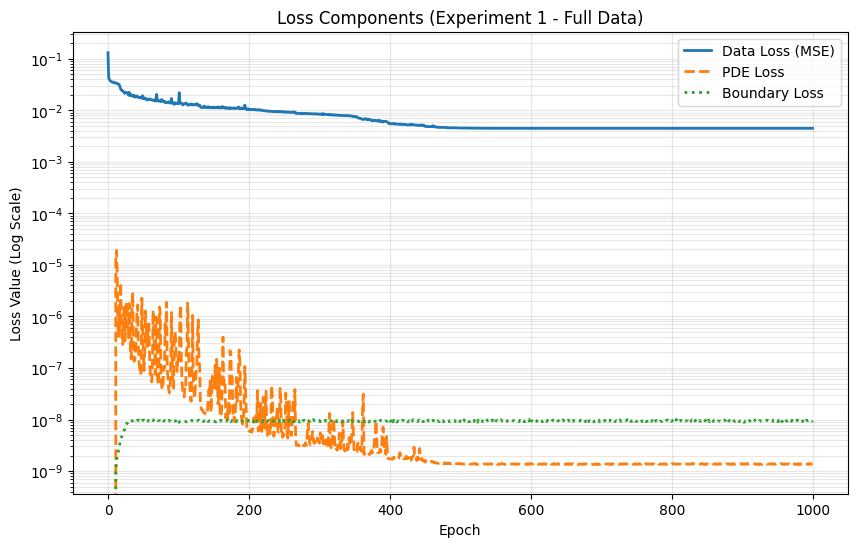

In [21]:
import time

# EXPERIMENT 1: Full Data (100%)
print("\n=== EXPERIMENT 1: Full Data (100%) ===")
# Using Optimized Parameters found in HPO step
print(f"Using Optimal Config: {best_config}")
hist_pinn_100, final_model = train_experiment("PINN (100%) [Optimized]",
                                    use_physics=True,
                                    epochs=1000,
                                    data_fraction=1.0,
                                    n_hidden=best_config['n_hidden'],
                                    lr=best_config['lr'],
                                    phy_scale=best_config['phy_weight'])

# --- LOSS COMPONENT PLOT (Experiment 1) ---
plt.figure(figsize=(10, 6))
plt.plot(hist_pinn_100['loss_data'], label='Data Loss (MSE)', linewidth=2)
# Scale Physics components for visibility if they are very small
# Or just plot raw to show their relative magnitude
plt.plot(hist_pinn_100['loss_phy'], label='PDE Loss', linewidth=2, linestyle='--')
plt.plot(hist_pinn_100['loss_bc'], label='Boundary Loss', linewidth=2, linestyle=':')
plt.yscale('log')
plt.title('Loss Components (Experiment 1 - Full Data)')
plt.ylabel('Loss Value (Log Scale)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()


=== EXPERIMENT 3: Scarce Data (10%) ===
Using Optimal Config: {'lr': np.float64(0.002), 'n_hidden': 256, 'phy_weight': np.float64(0.1)}

>>> Starting Experiment: PINN (10%) [Optimized]
    Physics Loss: ENABLED
    Params: LR=2e-03, Hidden=256, PhyScale=0.1
    Training on 400/4000 samples (10% of data)
Epoch 000 | Total: 3.51e-01 | Data: 3.51e-01 | PDE: 0.00e+00 | BC: 0.00e+00 | Val Err: 1.99 cm
Epoch 020 | Total: 4.75e-02 | Data: 4.72e-02 | PDE: 2.58e-04 | BC: 2.98e-08 | Val Err: 0.52 cm
Epoch 040 | Total: 4.18e-02 | Data: 4.18e-02 | PDE: 6.98e-06 | BC: 2.23e-08 | Val Err: 0.47 cm
Epoch 060 | Total: 3.98e-02 | Data: 3.98e-02 | PDE: 2.25e-06 | BC: 2.01e-08 | Val Err: 0.44 cm
Epoch 080 | Total: 3.74e-02 | Data: 3.74e-02 | PDE: 4.72e-07 | BC: 2.10e-08 | Val Err: 0.43 cm
Epoch 100 | Total: 3.66e-02 | Data: 3.66e-02 | PDE: 2.72e-07 | BC: 2.23e-08 | Val Err: 0.42 cm
Epoch 120 | Total: 3.59e-02 | Data: 3.59e-02 | PDE: 2.07e-07 | BC: 1.71e-08 | Val Err: 0.41 cm
Epoch 140 | Total: 3.35e-02 |

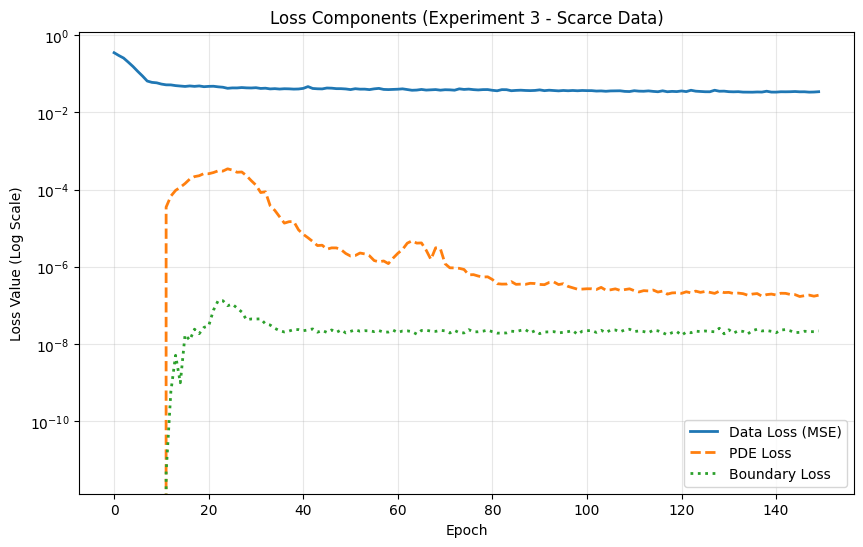

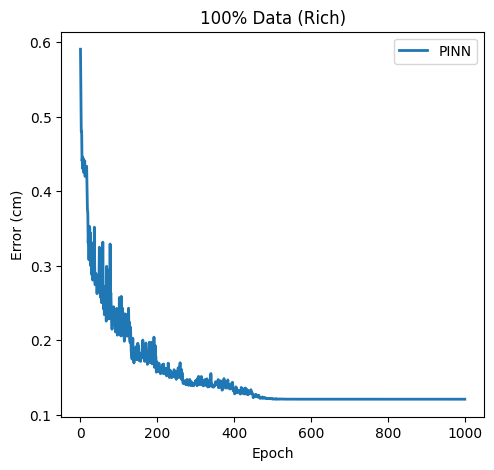

In [28]:
# EXPERIMENT 3: Scarce Data (10%)
print("\n=== EXPERIMENT 3: Scarce Data (10%) ===")
# Using Optimized Parameters found in HPO step
print(f"Using Optimal Config: {best_config}")
hist_pinn_10, model_pinn_10 = train_experiment("PINN (10%) [Optimized]",
                                               use_physics=True,
                                               epochs=150,
                                               data_fraction=0.1,
                                               n_hidden=best_config['n_hidden'],
                                               lr=best_config['lr'],
                                               phy_scale=best_config['phy_weight'])

# --- LOSS COMPONENT PLOT (Experiment 3) ---
plt.figure(figsize=(10, 6))
plt.plot(hist_pinn_10['loss_data'], label='Data Loss (MSE)', linewidth=2)
plt.plot(hist_pinn_10['loss_phy'], label='PDE Loss', linewidth=2, linestyle='--')
plt.plot(hist_pinn_10['loss_bc'], label='Boundary Loss', linewidth=2, linestyle=':')
plt.yscale('log')
plt.title('Loss Components (Experiment 3 - Scarce Data)')
plt.ylabel('Loss Value (Log Scale)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

# --- COMPARATIVE PLOTS ---
plt.figure(figsize=(12, 5))

# PLOT 1: Full Data (100%)
plt.subplot(1, 2, 1)
plt.plot(hist_pinn_100['val_error_cm'], label='PINN', linewidth=2)
plt.title('100% Data (Rich)')
plt.ylabel('Error (cm)')
plt.xlabel('Epoch')
plt.legend()


>>> Starting Semi-Supervised Experiment: Semi-Supervised (5% Labels)
    Labeled Samples:   200
    Unlabeled Samples: 3800
Epoch 000 | PINN Err: 2.07 cm
Epoch 010 | PINN Err: 1.48 cm
Epoch 020 | PINN Err: 1.08 cm
Epoch 030 | PINN Err: 0.68 cm
Epoch 040 | PINN Err: 0.61 cm
Epoch 050 | PINN Err: 0.59 cm
Epoch 060 | PINN Err: 0.80 cm
Epoch 070 | PINN Err: 0.60 cm
Epoch 080 | PINN Err: 0.57 cm
Epoch 090 | PINN Err: 0.53 cm
Epoch 100 | PINN Err: 0.52 cm
Epoch 110 | PINN Err: 0.50 cm
Epoch 120 | PINN Err: 0.63 cm
Epoch 130 | PINN Err: 0.58 cm
Epoch 140 | PINN Err: 0.60 cm


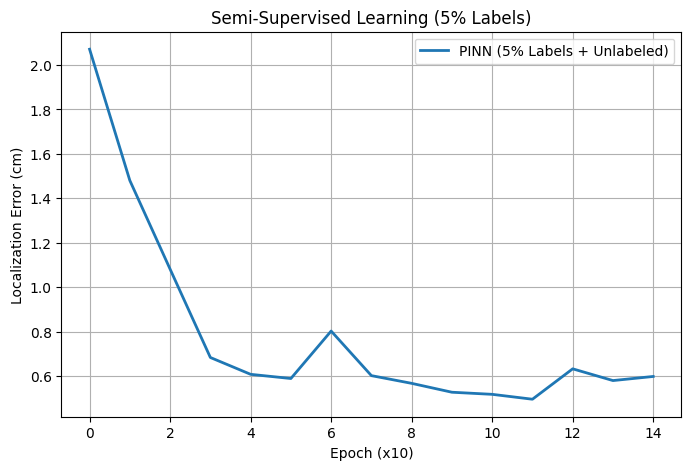

In [29]:
# --- SEMI-SUPERVISED TRAINING FUNCTION ---
def train_semisupervised(name, labeled_fraction=0.10, epochs=150, lr=1e-3):
    print(f"\n>>> Starting Semi-Supervised Experiment: {name}")

    n_labeled = int(len(X_train) * labeled_fraction)
    X_labeled = X_train[:n_labeled]
    Y_labeled = Y_train[:n_labeled]
    X_unlabeled = X_train[n_labeled:]

    print(f"    Labeled Samples:   {len(X_labeled)}")
    print(f"    Unlabeled Samples: {len(X_unlabeled)}")

    model_pinn = ConditionalMEGPinn(X_train.shape[1]).to(device)

    opt_pinn = optim.Adam(model_pinn.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    history = {'pinn_error': []}

    for epoch in range(epochs):
        model_pinn.train()

        # 1. PINN on Labeled Data
        perm_l = torch.randperm(len(X_labeled))
        for i in range(0, len(X_labeled), 32):
            idx = perm_l[i:i+32]
            X_b, Y_b = X_labeled[idx], Y_labeled[idx]
            opt_pinn.zero_grad()
            pred = model_pinn.predict_source(X_b)
            # MSE + Physics
            phy_term, bc_term = compute_physics_loss(model_pinn, pred)
            loss = loss_fn(pred, Y_b) + 0.05 * (phy_term + bc_term)
            loss.backward()
            opt_pinn.step()

        # 2. Unlabeled Physics
        n_unlabeled_batches = len(X_labeled) // 32
        perm_u = torch.randperm(len(X_unlabeled))
        for i in range(n_unlabeled_batches):
            idx = perm_u[i*32 : (i+1)*32]
            X_u = X_unlabeled[idx]
            opt_pinn.zero_grad()
            pred_u = model_pinn.predict_source(X_u)
            phy_term, bc_term = compute_physics_loss(model_pinn, pred_u)
            loss_phy = phy_term + bc_term
            (0.05 * loss_phy).backward()
            opt_pinn.step()

        # Validation
        if epoch % 10 == 0:
            model_pinn.eval()
            with torch.no_grad():
                pred_pinn = model_pinn.predict_source(X_val)

                # Unscale for reporting
                # Use COORD_SCALE_TENS for correct tensor broadcasting
                diff_pinn = (pred_pinn - Y_val) / COORD_SCALE_TENS
                err_pinn = np.mean(np.linalg.norm(diff_pinn.cpu().numpy(), axis=1)) * 100

            history['pinn_error'].append(err_pinn)
            print(f"Epoch {epoch:03d} | PINN Err: {err_pinn:.2f} cm")

    return history

# RUN EXPERIMENT 4: Scarce Labels (5%)
hist_semi = train_semisupervised("Semi-Supervised (5% Labels)", labeled_fraction=0.05, epochs=150)

# PLOT
plt.figure(figsize=(8, 5))
plt.plot(hist_semi['pinn_error'], label='PINN (5% Labels + Unlabeled)', linewidth=2)
plt.title('Semi-Supervised Learning (5% Labels)')
plt.ylabel('Localization Error (cm)')
plt.xlabel('Epoch (x10)')
plt.legend(); plt.grid(True); plt.show()

### Analysis of Interrupted Experiment 1 (PINN 100% Data, 1000 Epochs)

The training for Experiment 1 was interrupted after approximately **661 epochs** (Epoch 0 to Epoch 660). Below, we visualize the loss components and validation error up to this point.

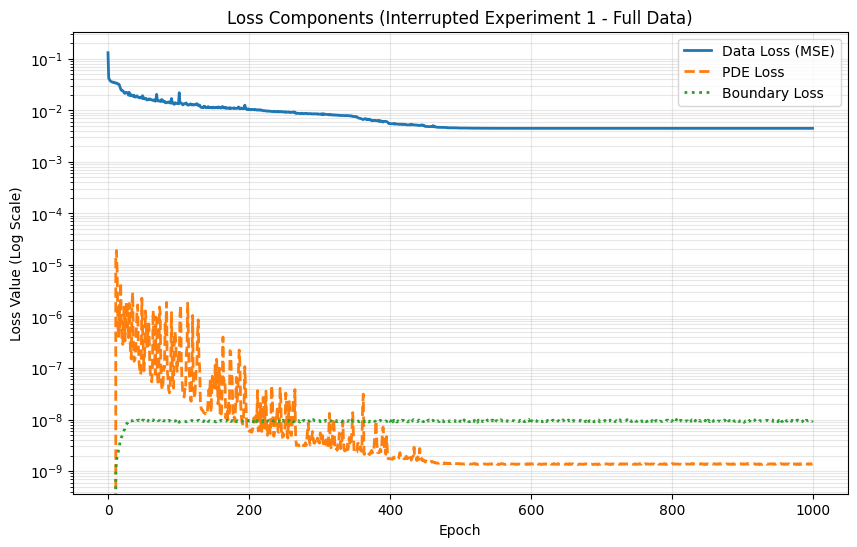

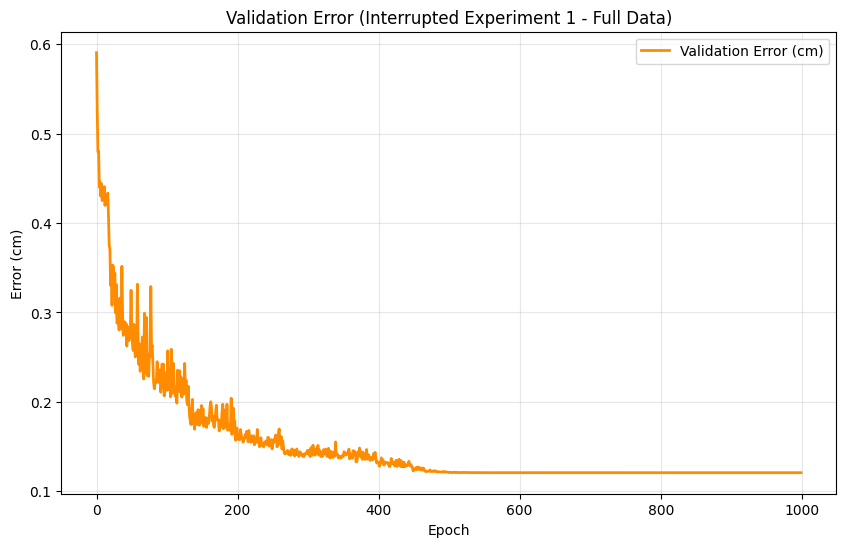


Summary of Interrupted Run:
  Epochs Completed: 1000
  Final Validation Error: 0.12 cm


In [30]:
# --- LOSS COMPONENT PLOT (Interrupted Experiment 1) ---
import matplotlib.pyplot as plt

if 'hist_pinn_100' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(hist_pinn_100['loss_data'], label='Data Loss (MSE)', linewidth=2)
    plt.plot(hist_pinn_100['loss_phy'], label='PDE Loss', linewidth=2, linestyle='--')
    plt.plot(hist_pinn_100['loss_bc'], label='Boundary Loss', linewidth=2, linestyle=':')
    plt.yscale('log')
    plt.title('Loss Components (Interrupted Experiment 1 - Full Data)')
    plt.ylabel('Loss Value (Log Scale)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.show()

    # --- VALIDATION ERROR PLOT (Interrupted Experiment 1) ---
    plt.figure(figsize=(10, 6))
    plt.plot(hist_pinn_100['val_error_cm'], label='Validation Error (cm)', linewidth=2, color='darkorange')
    plt.title('Validation Error (Interrupted Experiment 1 - Full Data)')
    plt.ylabel('Error (cm)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.show()

    # --- Summary of Interrupted Run ---
    completed_epochs = len(hist_pinn_100['val_error_cm'])
    final_val_error = hist_pinn_100['val_error_cm'][-1]
    print(f"\nSummary of Interrupted Run:")
    print(f"  Epochs Completed: {completed_epochs}")
    print(f"  Final Validation Error: {final_val_error:.2f} cm")
else:
    print("Error: 'hist_pinn_100' not found. Please ensure Experiment 1 was run (and potentially interrupted) before analyzing.")